This notebook is taken from this tutorial https://jaketae.github.io/study/word2vec/ on implementing word2vec from scratch

In [1]:
import pandas as pd
import numpy as np

In [2]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

### Tokenization

In [3]:
import re
from string import punctuation 

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    tokens = pattern.findall(text.lower())
    return tokens

def mapping(tokens):
    '''create a map between tokens and indices'''
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word


In [4]:
tokens = tokenize(text)

In [5]:
word_to_idex, idex_to_word = mapping(tokens)
#word_to_idex

### Generate training Data
- We know tokens are strings, we need to encode them numerically using one-hot vectorization. 
- We also need to generate the input and target values.
- we need to also create the context of each word

In [6]:
np.random.seed(42)


def generate_training_data(tokens, word_to_idex, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_idex[tokens[i]], len(word_to_idex)))
            y.append(one_hot_encode(word_to_idex[tokens[j]], len(word_to_idex)))
    
    return np.asarray(X), np.asarray(y)


def concat(*iterables):
    for iterable in iterables:
        yield from iterable


def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res


In [7]:
X, y = generate_training_data(tokens, word_to_idex, 2)

In [8]:
X.shape

(330, 60)

In [9]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [10]:
y.shape

(330, 60)

Both X and y are matrices with 330 rows and 60 columns. 
- 330 is the number of training examples we have (this number to have been larger had we used a larger window).
- 60 is the size of our corpus, or the number of unique tokens we have in the original text.  
Since we have one-hot encoded both the input and output as 60-dimensional sparse vectors, this is expected.

### Embedding Model

The representation we will use for the model is a Python dictionary, whose values are the weight matrices and keys, the name with which we will refer to the weight matrices "W1" and "W2" to refer to these weights.

In [11]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model


In [12]:
model = init_network(len(word_to_idex), 10)

### Forward Propagation

In [13]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    
    return cache

In [14]:
# check the dimensionality of the matrices
(X @ model["w1"]).shape

(330, 10)

All the 330 tokens in the text to be converted into 10-dimensional vectors

In [15]:
# check the dimensionality after passing through the second layer
(X @ model["w1"] @ model["w2"]).shape

(330, 60)

### Backpropagation

In [16]:
def backward(model, X, y, alpha):
    
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    
    return cross_entropy(cache["z"], y)


In [17]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

### training the model

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

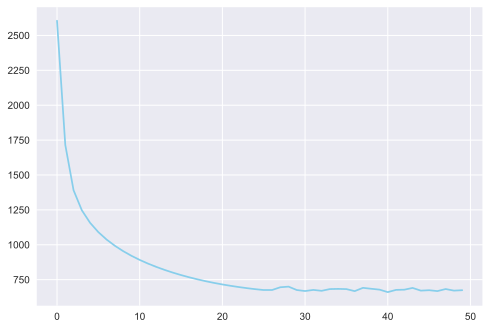

In [19]:
n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

We can perform sanity to see which token our model predicts given the word “learning.”

In [20]:
learning = one_hot_encode(word_to_idex["learning"], len(word_to_idex))
result = forward(model, [learning], return_cache=False)[0]

for word in (idex_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
build
intelligence
so
are
the
algorithms
do
a
is
learning
artificial
mathematical
such
needed
variety
seen
to
conventional
study
develop
in
infeasible
difficult
applications
subset
on
based
wide
model
explicitly
decisions
programmed
without
make
known
training
it
data
used
of
being
or
where
filtering
tasks
perform
experience
vision
sample
as
predictions
order
through
and
email
that
improve
computer
automatically
